# Determining the tolerance of style errors in Python ($\tau$) with [Flake8](http://flake8.pycqa.org/en/latest/)

## Authors: 
- [Juan B Cabral](mailto:jbc.develop@gmail.com), 
- [Bruno Sanchez](mailto:bruno.sanchez.63@gmail.com), 
- [Martin Beroiz](mailto:martinberoiz@gmail.com)


[IATE](http://iate.oac.uncor.edu/) - 
[CONICET](http://www.conicet.gov.ar/) - 
[FAMaF](http://www.famaf.unc.edu.ar/) - 
[FCEIA-UNR](http://web.fceia.unr.edu.ar/) - 
[UTRGV](http://www.utrgv.edu/en-us/)

> Part of [Corral](https://github.com/toros-astro/corral) and 
> [TOROS](http://toros.phys.utb.edu/TOROS/Welcome.html)

In [1]:
%matplotlib inline

from collections import Counter
import warnings

import matplotlib.pyplot as plt

import seaborn
seaborn.set()

import pandas as pd

import numpy as np

from scipy import stats as st

from IPython.display import display, Markdown as md

import statsmodels.api as smapi
import statsmodels.graphics as smgraphics

import metrics

warnings.simplefilter("ignore", FutureWarning)

In [2]:
def Q(a):
    "Promedio de cuartiles"
    return np.average(np.percentile(a, (25, 75)))


def TRI(a):
    """Trimedian"""
    Me = np.median(a)
    C25, C75 = np.percentile(a, (25, 75))
    values = np.array([C25, Me, Me, C75])
    return np.average(values)


def MID(a):
    """Promedio inter cuartil. Calcula el promedio de los valores del 50% central
    del array"""
    if not isinstance(a, np.ndarray):
        a = np.array(a)
    l, u = np.percentile(a, (25, 75))
    central = a[np.nonzero((a >= l) & (a <= u))]
    return np.average(central)

## 1. Resume

In [3]:
df = metrics.df[["file_size", "flake8_errors"]]
df.describe()

,file_size,flake8_errors
count,4280.000000,4280.000000
mean,2786.423131,40.438785
std,8980.746072,182.514461
min,1.000000,0.000000
25%,479.750000,4.000000
50%,1132.500000,11.000000
75%,2730.500000,31.000000
max,417760.000000,8154.000000


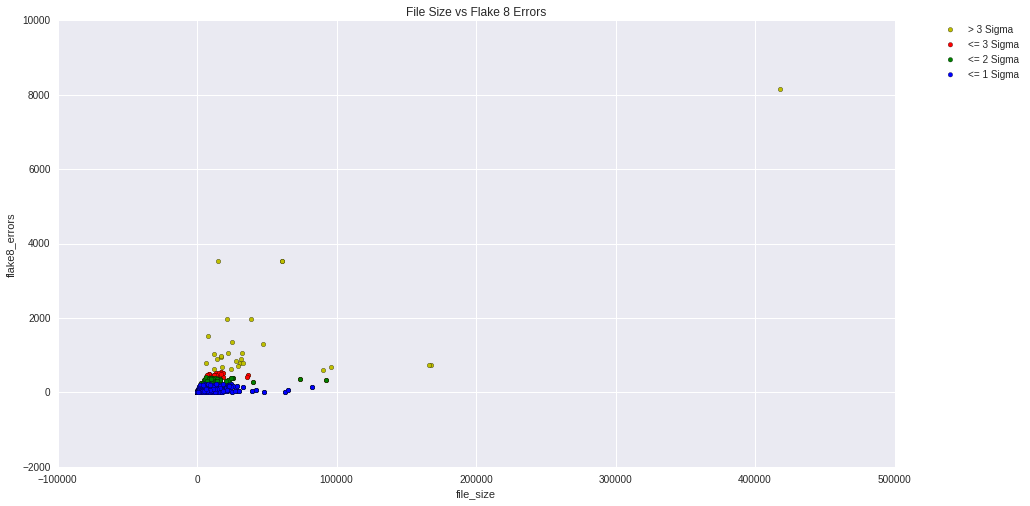

,25%,50%,75%,MID,Q,TRI,count,max,mean,min,std,wmean
label,,,,,,,,,,,,
<= 1 Sigma,4.0,10.0,28.0,11.907372,16.0,13.00,4163.0,220.0,23.947153,0.0,34.924014,4.917206
<= 2 Sigma,4.0,11.0,30.0,12.457875,17.0,14.00,4229.0,402.0,28.372192,0.0,49.808422,5.033357
<= 3 Sigma,4.0,11.0,30.0,12.457875,17.0,14.00,4252.0,545.0,30.745061,0.0,59.264002,5.083658
> 3 Sigma,4.0,11.0,31.0,12.667723,17.5,14.25,4280.0,8154.0,40.438785,0.0,182.514461,5.168339


In [4]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

mean = df.flake8_errors.mean()
std = df.flake8_errors.std()
max = df.flake8_errors.max()

limits = [
    ("<= 1 Sigma", "b", mean + std),
    ("<= 2 Sigma", "g", mean + std * 2),
    ("<= 3 Sigma", "r", mean + std * 3),
    ("> 3 Sigma", "y", max),
]

data = []
for label, color, limit in reversed(limits):
    filtered = df[df.flake8_errors <= limit]
    
    resume = filtered.describe().flake8_errors.to_dict()
    resume.update(
        label=label, 
        wmean=np.average(filtered.flake8_errors, weights=1/filtered.file_size),
        Q=Q(filtered.flake8_errors), TRI=TRI(filtered.flake8_errors), 
        MID=MID(filtered.flake8_errors))
    data.append(resume)
    
    filtered.plot.scatter(x="file_size", y="flake8_errors", color=color, ax=axes, label=label)
    
resume = pd.DataFrame(list(reversed(data)))
resume = resume.set_index(["label"])

axes.set_title("File Size vs Flake 8 Errors")
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

display(resume)

## 2. Remove Outliers

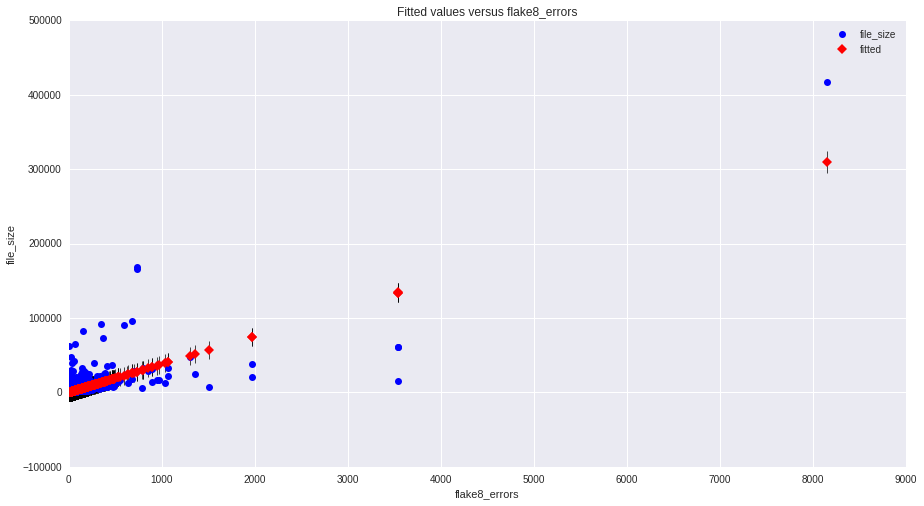

,file_size,flake8_errors,order
0,89942,596,120
1,15323,3536,127
2,82165,152,223
3,167958,732,335
4,33257,140,403
5,24578,28,665
6,29360,47,765
7,39714,36,1144
8,96188,676,1303
9,417760,8154,1380


In [5]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
regression = smapi.OLS(df.file_size, df.flake8_errors).fit()
smgraphics.regressionplots.plot_fit(regression, 0, ax=axes)


plt.show()

test = regression.outlier_test()
outliers = pd.DataFrame([
    {"order": i, "file_size": df.file_size[i], "flake8_errors": df.flake8_errors[i]} 
    for i,t in enumerate(test.icol(2)) 
    if t < 0.9])

display(outliers)

In [6]:
df = df[~df.index.isin(outliers.order)]
df.describe()

,file_size,flake8_errors
count,4251.000000,4251.000000
mean,2358.095742,33.255940
std,3616.876507,76.722868
min,1.000000,0.000000
25%,476.500000,4.000000
50%,1122.000000,11.000000
75%,2680.500000,30.000000
max,47494.000000,1298.000000


## 3. Sigma Clip

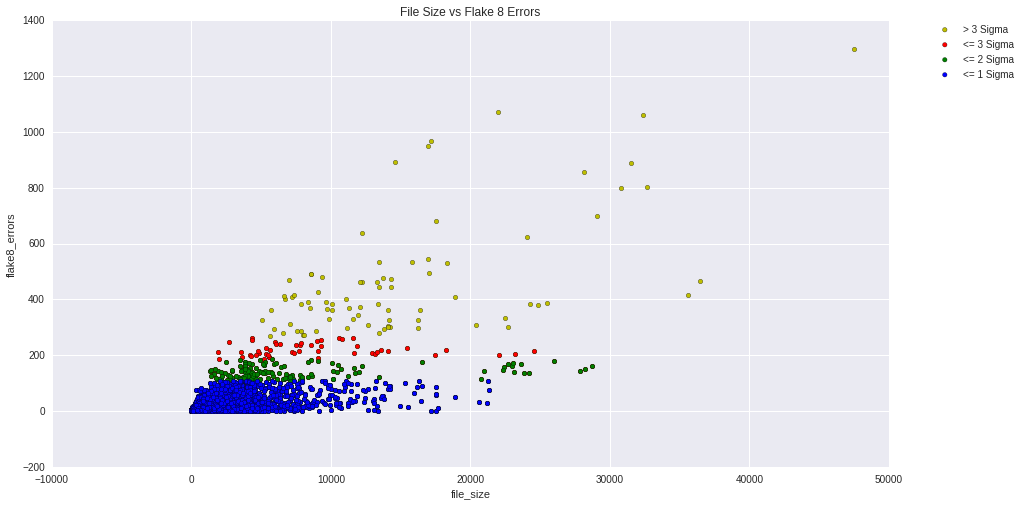

,25%,50%,75%,MID,Q,TRI,count,max,mean,min,std,wmean
label,,,,,,,,,,,,
<= 1 Sigma,3.0,9.0,24.0,10.045798,13.5,11.25,3980.0,109.0,18.405276,0.0,22.310210,4.631727
<= 2 Sigma,4.0,10.0,27.0,11.692234,15.5,12.75,4120.0,186.0,22.504126,0.0,31.203037,4.859518
<= 3 Sigma,4.0,10.0,29.0,12.116822,16.5,13.25,4170.0,263.0,24.875540,0.0,37.829244,4.953791
> 3 Sigma,4.0,11.0,30.0,12.444954,17.0,14.00,4251.0,1298.0,33.255940,0.0,76.722868,5.111754


In [7]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

mean = df.flake8_errors.mean()
std = df.flake8_errors.std()
max = df.flake8_errors.max()

limits = [
    ("<= 1 Sigma", "b", mean + std),
    ("<= 2 Sigma", "g", mean + std * 2),
    ("<= 3 Sigma", "r", mean + std * 3),
    ("> 3 Sigma", "y", max),
]

data = []
for label, color, limit in reversed(limits):
    filtered = df[df.flake8_errors <= limit]
    
    resume = filtered.describe().flake8_errors.to_dict()
    resume.update(
        label=label, 
        wmean=np.average(filtered.flake8_errors, weights=1/filtered.file_size),
        Q=Q(filtered.flake8_errors), TRI=TRI(filtered.flake8_errors), 
        MID=MID(filtered.flake8_errors))
    data.append(resume)
    
    filtered.plot.scatter(x="file_size", y="flake8_errors", color=color, ax=axes, label=label)
    
resume = pd.DataFrame(list(reversed(data)))
resume = resume.set_index(["label"])

axes.set_title("File Size vs Flake 8 Errors")
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

display(resume)